# pNEUMA simulator

Data from: https://open-traffic.epfl.ch

Optimal velocity function: 

$V:s \mapsto V(s),$ \
$V(s) = \max\{0, \ v_0 -v_0\exp(-\lambda v_0^{-1}(s -s_{\text{jam}})) \},$ \
$V'(s) = H(s -s_{\text{jam}})\lambda\exp(-\lambda v_0^{-1}(s -s_{\text{jam}})),$ \
$V^{-1}(v) = -\lambda^{-1}v_0 \log(1-v_0^{-1}v)+s_{\text{jam}},\ 0<v<v_0.$

Heterogeneous OV Model with Relaxed Noise: 

$\begin{equation}
  \begin{cases}
    \dot \varepsilon_n = -b^{-1}\varepsilon_n +\sigma_R\sqrt{2 b^{-1}} \xi_n,\ b>0,\\
    \dot v_n = \tau_n^{-1}[{( V_n(s_n)+\varepsilon_n)\times w(\Delta t)-v_n}],\ \tau_n>0,\\
    \dot x_n = v_n,
  \end{cases}
\end{equation}$

$
\begin{equation}
  \begin{cases}
  \varepsilon_n(t+\delta) = (1-\delta \tilde b^{-1})\varepsilon_n(t) + \tilde\sigma_R\sqrt{\delta 2 \tilde b^{-1}} \eta_n,\ \eta_n \sim \mathcal{N}(0,\,1),\\
    v_n(t+\delta) = v_n(t) + \delta \frac{(V_n(s_n) +\varepsilon_n(t+\delta))\times w(\Delta t)-v_n(t)}{\tau_n},\\
    x_n(t+\delta) = x_n(t) + \delta v_n(t+\delta).
  \end{cases}
\end{equation}$

Anticipatory Operational Navigation: 

$\begin{equation}
  f(\alpha)=\min\{d_{\max}, v_0 \Delta t(\alpha)\}
\end{equation}$
$\begin{equation}
  d(\alpha)^2 = d_{\max}^2 +f(\alpha)^2 - 2 d_{\max}f(\alpha)\cos(\alpha_0-\alpha)
\end{equation}$
$\begin{equation}
  \alpha_{\text{des}} = \underset{}{\mathrm{argmin}} {d(\alpha)^2}
\end{equation}$
$\begin{equation}
  \dot \alpha = \tau^{-1}\left[\alpha_{\text{des}}-\alpha\right]
\end{equation}$

In [1]:
import os
import json
import zipfile
import logging
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation
from joblib import Parallel, delayed
from matplotlib import rcParams
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from scipy.stats import linregress
from numpy.polynomial import Polynomial
from numpy import array, arange, where, loadtxt
from math import exp

In [2]:
from pNeuma_simulator import params
from pNeuma_simulator.initialization import PoissonDisc
from pNeuma_simulator.simulate import batch
from pNeuma_simulator.results import normalized, loader, aggregate, percolate, zipdir, confidence_interval
from pNeuma_simulator.animations import ring

In [3]:
warnings.filterwarnings("ignore")
rcParams["animation.embed_limit"] = 2**128
rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
        "mathtext.fontset": "stixsans",
        "mathtext.default": "regular",
        "font.size": 8,
        "axes.titlesize": 8,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.linewidth": 0.25,
        "xtick.major.width": 0.25,
        "ytick.major.width": 0.25,
        "xtick.minor.width": 0.25,
        "ytick.minor.width": 0.25,
    }
)
logging.getLogger("matplotlib.font_manager").disabled = True

## 2D simulator

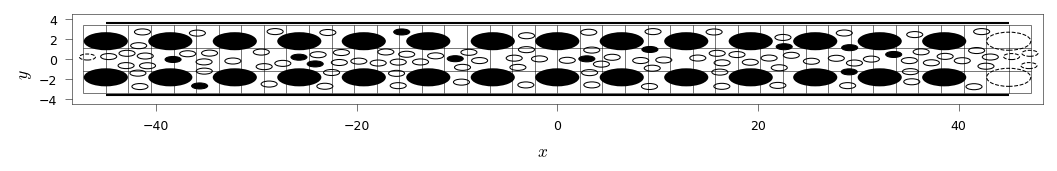

In [4]:
# Pseudorandom number generator
seed = 1024
rng = np.random.default_rng(seed)
n_cars = 14
n_moto = 12
# k = params.k
k = 128
sampler = PoissonDisc(
    n_cars, n_moto, cell=params.cell, L=params.L, W=params.cell * 3, k=k, clearance=params.clearance, rng=rng
)
samples, images = sampler.sample(rng)
c_samples = samples[: 2 * n_cars]
m_samples = samples[2 * n_cars :]
markings = arange(-sampler.W / 2, 3 * sampler.W / 4, sampler.W / 2)

fig, ax = plt.subplots(figsize=(2 * 8.7 * params.cm, 2.5 * params.cm), dpi=150)
ax.set_aspect("equal")
for sample in samples:
    if sample in c_samples:
        sample.styles = {"ec": "none", "fc": "k", "fill": True, "lw": 0.6}
    else:
        sample.styles = {"ec": "k", "fill": False, "lw": 0.5}
    sample.draw(ax)
for image in images:
    image.styles = {"ec": "k", "fill": False, "lw": 0.5, "ls": "--"}
    image.draw(ax)
for m_sample in rng.choice(m_samples, n_moto, replace=False):
    m_sample.styles = {"ec": "none", "fc": "k", "fill": True, "lw": 0.5}
    m_sample.draw(ax)
ax.hlines(
    [-params.lane, params.lane],
    xmin=-sampler.width / 2,
    xmax=sampler.width / 2,
    color="k",
    ls="-",
    lw=1,
)
ax.vlines(
    sampler.x_boundaries,
    ymin=-3 * sampler.cell / 2,
    ymax=3 * sampler.cell / 2,
    color="k",
    lw=0.25,
)
ax.hlines(
    sampler.y_boundaries,
    xmin=-sampler.nx * sampler.cell / 2,
    xmax=sampler.nx * sampler.cell / 2,
    color="k",
    lw=0.25,
)
plt.xlim(-(sampler.nx + 1) * sampler.cell / 2, (sampler.nx + 1) * sampler.cell / 2)
plt.ylim(-2 * sampler.cell, 2 * sampler.cell)
ax.set_xlabel("$x$ (m)", usetex=True)
ax.set_ylabel("$y$ (m)", usetex=True)
ax.set_yticks(arange(-4, 5, 2))
fig.tight_layout(pad=0)
# if n_moto == 0:
#    plt.savefig(f"darts_c{n_cars}m{n_moto}.pdf", format="pdf", transparent=True)
# else:
#    plt.savefig(f"darts_c{n_cars}m{n_moto}k{k}.pdf", format="pdf", transparent=True)

In [5]:
samples[-1].encode()

{'ID': 128,
 'mode': 'Moto',
 'a_des': 0,
 'a0': 0,
 'ttc': None,
 'f_a': None,
 'leader': None,
 'gap': None,
 'tau': None,
 'lam': None,
 'v0': None,
 'd': None,
 'pos': array([41.53960118, -2.7342286 ]),
 'vel': array([0., 0.]),
 'theta': 0.0,
 'interactions': []}

In [6]:
# Space discretization
x = arange(-params.L / 2 + params.grid / 2, params.L / 2, params.grid)
y = arange(-params.lane - params.grid / 2, params.lane + params.grid, params.grid)
xv, yv = np.meshgrid(x, y)
yv = np.flip(yv)
shape = yv.shape

In [7]:
path = "./output/"
os.makedirs(path, exist_ok=True)
# Combinatorial configurations
n_veh = 8
scale = 2
l_cars = scale * arange(1, n_veh, 1)
l_moto = scale * arange(0, n_veh - 1, 1)
permutations = list(itertools.product(l_cars, l_moto))
len(permutations)

49

In [8]:
run = False
# TODO: update code to match function in new version
epochs = 4
default_rng = np.random.default_rng(1024)
seeds = default_rng.integers(1e8, size=epochs * len(permutations))
if run:
    with Parallel(n_jobs=-1, prefer="processes") as master:
        for n, permutation in tqdm(enumerate(permutations)):
            start = n * epochs
            end = (n + 1) * epochs
            items = master(delayed(batch)(seed, permutation) for seed in seeds[start:end])
            # Dump result to a JSON data specification
            with open(f"{path}{permutation}.json", "w") as outfile:
                json.dump(items, outfile)
            # Compress as Zip and delete original JSON
            with zipfile.ZipFile(f"{path}{permutation}.zip", "w", zipfile.ZIP_DEFLATED) as zipf:
                zipdir(path, zipf)
            print(permutation)
            items = None

# Results

In [9]:
# consider only this last fraction of the simulated data
keep = 1 / 3

In [10]:
read = not run
path = "./output/"
os.makedirs(path, exist_ok=True)

In [11]:
if read:
    with open(f"{path}results.json", "r") as openfile:
        results = json.load(openfile)

In [12]:
# probe = False
# if probe:
#     permutation = (4, 6)
#     items = loader(permutation, path)
#     accidents = 0
#     locations = []
#     for item in items:
#         if isinstance(item[0], list):
#             pass
#         else:
#             locations.append(item)
#             accidents += 1
#     error = accidents / len(items)
#     print(error)

In [13]:
compilation = False
if compilation:
    results = {}
    for permutation in permutations:
        n_cars, n_moto = permutation
        results[str(permutation)] = {
            "VKT_cars": [],
            "VHT_cars": [],
            "VKT_moto": [],
            "VHT_moto": [],
        }
        items = loader(permutation, path)
        accidents = 0
        for item in items:
            if isinstance(item[0], list):
                (
                    VKT_cars,
                    VHT_cars,
                    VKT_moto,
                    VHT_moto,
                ) = aggregate(item[0], n_cars, n_moto)
                results[str(permutation)]["VKT_cars"].append(VKT_cars)
                results[str(permutation)]["VHT_cars"].append(VHT_cars)
                results[str(permutation)]["VKT_moto"].append(VKT_moto)
                results[str(permutation)]["VHT_moto"].append(VHT_moto)
            else:
                accidents += 1
        error = accidents / len(items)
        results[str(permutation)]["error"] = error
        if n_cars > 2 and n_moto > 2:
            percolation = percolate(items, n_moto, rng, start=5)
        else:
            percolation = None
        results[str(permutation)]["percolation"] = percolation
        items = None

In [14]:
# path = "./output/"
# os.makedirs(path, exist_ok=True)
write = run
if write:
    with open(f"{path}results.json", "w") as outfile:
        json.dump(results, outfile)

In [15]:
# path = "./output/"
# os.makedirs(path, exist_ok=True)
read = not run
if read:
    with open(f"{path}results.json", "r") as openfile:
        results = json.load(openfile)

In [16]:
l_flow_cars = []
l_flow_moto = []
l_speed_cars = []
l_speed_moto = []
l_sem_cars = []
l_sem_moto = []
l_error = []
for permutation in permutations:
    flow_cars = np.nanmean(results[str(permutation)]["VKT_cars"]) / (2e-6 * keep * params.T * params.L / params.factor)
    speed_cars = np.nanmean(results[str(permutation)]["VKT_cars"]) / np.nanmean(results[str(permutation)]["VHT_cars"])
    sem_cars = confidence_interval(results[str(permutation)]["VKT_cars"], rng) / np.nanmean(
        results[str(permutation)]["VHT_cars"]
    )
    if permutation[1] > 0:
        flow_moto = np.nanmean(results[str(permutation)]["VKT_moto"]) / (
            2e-6 * keep * params.T * params.L / params.factor
        )
        speed_moto = np.nanmean(results[str(permutation)]["VKT_moto"]) / np.nanmean(
            results[str(permutation)]["VHT_moto"]
        )
        sem_moto = confidence_interval(results[str(permutation)]["VKT_moto"], rng) / np.nanmean(
            results[str(permutation)]["VHT_moto"]
        )
    else:
        speed_moto = np.nan
        sem_moto = np.nan
        flow_moto = np.nan
    error = results[str(permutation)]["error"]
    l_flow_cars.append(flow_cars)
    l_flow_moto.append(flow_moto)
    l_speed_cars.append(speed_cars)
    l_speed_moto.append(speed_moto)
    l_sem_cars.append(sem_cars)
    l_sem_moto.append(sem_moto)
    l_error.append(error)

In [17]:
moto_matrix, car_matrix = np.meshgrid(arange(n_veh - 1), arange(n_veh - 1))
car_matrix += 1
car_matrix *= 2
moto_matrix *= 2
car_density = 1e3 * car_matrix / params.L
moto_density = 1e3 * moto_matrix / (2 * params.L)
flow_matrix_cars = array(l_flow_cars).reshape((n_veh - 1, n_veh - 1))
flow_matrix_moto = array(l_flow_moto).reshape((n_veh - 1, n_veh - 1))
speed_matrix_cars = array(l_speed_cars).reshape((n_veh - 1, n_veh - 1))
speed_matrix_moto = array(l_speed_moto).reshape((n_veh - 1, n_veh - 1))
sem_matrix_cars = array(l_sem_cars).reshape((n_veh - 1, n_veh - 1))
sem_matrix_moto = array(l_sem_moto).reshape((n_veh - 1, n_veh - 1))
error_matrix = array(l_error).reshape((n_veh - 1, n_veh - 1))
percent_matrix = moto_matrix / (2 * car_matrix + moto_matrix)

## Rejection rate

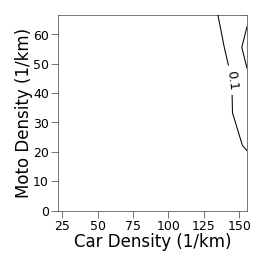

In [18]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    error_matrix,
    levels=arange(0.1, 1, 0.1),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
ax.clabel(surface, surface.levels[::2], inline=True, fontsize=6)
fig.tight_layout(pad=0)

In [19]:
# _ = plt.imshow(error_matrix.T, origin="lower")
# _ = plt.plot(error_matrix[-1], c="k")

## Effect of traffic composition on the capacity

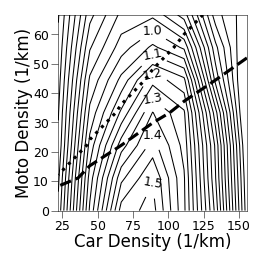

In [20]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
section = ax.contour(
    car_density,
    moto_density,
    percent_matrix,
    levels=[0, 0.25, 0.35],
    colors=[
        "none",
        "k",
        "k",
    ],
    linestyles=[
        "-",
        "--",
        ":",
    ],
    lw=1.75,
)
major = ax.contour(
    car_density,
    moto_density,
    flow_matrix_cars / 1000,
    levels=arange(0.45, 1.6, 0.05),
    colors="k",
    frameon=True,
    linewidths=0.5,
)
ax.clabel(major, major.levels[3::2][4:], inline=True, fontsize=6)
minor = ax.contour(
    car_density,
    moto_density,
    flow_matrix_cars,
    levels=arange(450, 1600, 1),
    colors="none",
    frameon=True,
    linewidths=0.5,
)
l_points, l_response = normalized(minor, section)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"flow_surface.pdf", format="pdf", transparent=True)

In [21]:
# _ = plt.imshow(flow_matrix_cars.T, origin="lower")

In [22]:
in_path = "./input/"
os.makedirs(in_path, exist_ok=True)

In [23]:
with open(f"{in_path}validation.txt", "r") as openfile:
    # results = json.load(openfile)
    l_density, l_flow = loadtxt("./input/validation.txt")
mask = array(l_flow) > 400
a_density = array(l_density)[mask]
a_flow = array(l_flow)[mask]

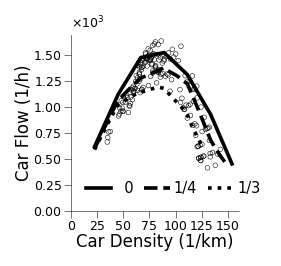

In [24]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
linestyles = [
    "-",
    "--",
    ":",
    "-.",
]
labels = ["  0", "1/4", "1/3"]
for n, (points, response) in enumerate(zip(l_points, l_response)):
    variable = []
    for point in l_points[n]:
        variable.append(point[0])
    l_variable = array(variable)
    order = np.argsort(variable)
    variable = np.sort(variable)
    response = array(l_response[n])[order]
    _ = plt.plot(
        variable,
        response,
        c="k",
        ls=linestyles[n],
        label=labels[n],
        clip_on=False,
        lw=1.75,
    )
plt.scatter(
    a_density,
    a_flow,
    ec="k",
    fc="none",
    s=5,
    lw=0.25,
    clip_on=False,
    zorder=10,
)
ax.set_ylim(0, None)
ax.set_xlim(0, None)
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Car Flow (1/h)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
ax.set_xticks(arange(0, 175, 25))
plt.legend(
    loc=(0.05, 0.05),
    frameon=False,
    handletextpad=0.25,
    handlelength=1.75,
    ncol=3,
    columnspacing=0.75,
    fontsize=7,
)
mf = mticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((-2, 2))
plt.gca().yaxis.set_major_formatter(mf)
fig.tight_layout(pad=0)
# plt.savefig(f"flow.pdf", format="pdf", transparent=True)

In [25]:
sigma = 0.1
gauss = gaussian_filter(speed_matrix_cars, [sigma, sigma], truncate=100)
speed_matrix_cars_f = gauss

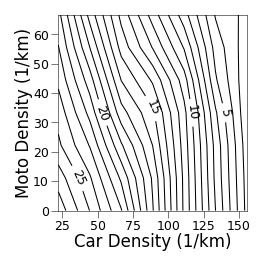

In [26]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    speed_matrix_cars_f,
    levels=arange(0, 40, 1),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.clabel(surface, surface.levels[::5], inline=True, fontsize=6)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"speed_cars.pdf", format="pdf", transparent=True)

In [27]:
# _ = plt.imshow(speed_matrix_cars.T, origin="lower")

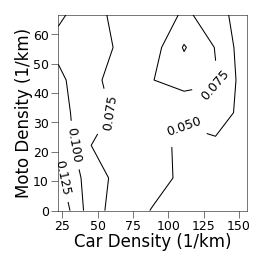

In [28]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    sem_matrix_cars,
    levels=arange(0, 1, 0.025),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.clabel(surface, surface.levels, inline=True, fontsize=6)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)

In [29]:
# _ = plt.imshow(sem_matrix_cars.T, origin="lower")

In [30]:
sigma = 0.5
gauss = gaussian_filter(speed_matrix_moto[:, 1:], [sigma, sigma], truncate=100)
speed_matrix_moto_f = np.hstack((speed_matrix_moto[:, 0][:, np.newaxis], gauss))

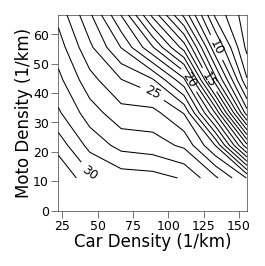

In [31]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    speed_matrix_moto_f,
    levels=arange(0, 40, 1),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.clabel(surface, surface.levels[::5], inline=True, fontsize=6)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"speed_moto.pdf", format="pdf", transparent=True)

In [32]:
# _ = plt.imshow(speed_matrix_moto_f.T, origin="lower")

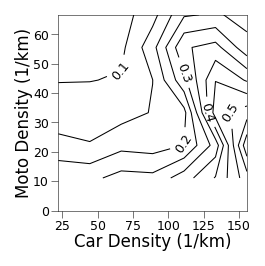

In [33]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    sem_matrix_moto,
    levels=arange(0, 2, 0.05),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
ax.clabel(surface, surface.levels[::2], inline=True, fontsize=6)
fig.tight_layout(pad=0)

In [34]:
# _ = plt.imshow(
#    sem_matrix_moto.T,
#    origin="lower",
# )

## Phase transitions

In [35]:
T_max = round(exp(params.CM))
NU = 1.096854  # theoretical exponent for directed percolation in 1D

In [36]:
def loss(x, y, x_star):
    renorm = np.abs(x - x_star)
    slope, _, _, _, _ = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
    return abs(NU - slope)

In [37]:
def fit(x, y):
    # https://stackoverflow.com/questions/3843017/
    zero_crossings = where(np.diff(np.sign(y)))[0]
    x0 = x[zero_crossings[0]]
    # https://stackoverflow.com/questions/24767191/
    res = minimize(lambda x_star: loss(x, y, x_star), method="Nelder-Mead", x0=x0)
    popt = res.x[0]
    return popt

In [38]:
l_T_c = []
l_p_c = []
l_slope = []
r_values = []
p_values = []
for permutation in permutations:
    if permutation[0] > 2 and permutation[1] > 4:
        x, y, _, _ = results[str(permutation)]["percolation"]
        x, y = array(x), array(y)
        try:
            T_c = fit(x, y)
            renorm = np.abs(T_c - x)
            slope, intercept, r_value, p_value, std_err = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
            r_values.append(r_value)
            p_values.append(p_value)
            p_c = 1 - T_c / T_max
            if r_value < 0.95:
                print(permutation, r_value)
                T_c = np.nan
                p_c = np.nan
            else:
                l_slope.append(slope)
        except:
            print(f"problem{permutation}")
            break
    else:
        T_c = np.nan
        p_c = np.nan
    l_T_c.append(T_c)
    l_p_c.append(p_c)
moto_matrix, car_matrix = np.meshgrid(arange(n_veh - 1), arange(n_veh - 1))
car_matrix += 1
car_matrix *= 2
moto_matrix *= 2
percolation_matrix = array(l_p_c).reshape((n_veh - 1, n_veh - 1))

In [39]:
round(np.mean(r_values), 4), round(np.mean(p_values), 15), round(np.std(l_slope), 6)

(0.9966, 5e-15, 1.4e-05)

In [40]:
# _ = plt.imshow(
#    percolation_matrix.T,
#    origin="lower",
# )

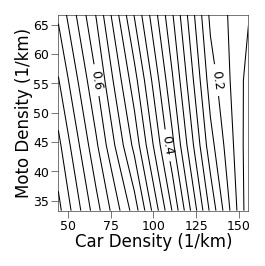

In [41]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density[1:, 3:],
    moto_density[1:, 3:],
    percolation_matrix[1:, 3:],
    levels=arange(0, 1, 0.025),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(50, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
ax.clabel(surface, surface.levels[::8], inline=True, fontsize=6)
fig.tight_layout(pad=0)

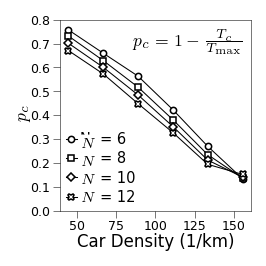

In [42]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
markers = ["o-", "s-", "D-", "X-"]
for i in range(4):
    ax.plot(
        car_density[1:, i + 3],
        percolation_matrix[1:, i + 3],
        markers[i],
        c="k",
        lw=0.5,
        ms=3,
        mfc="w",
        mew=".75",
        label=f"N  = {2*(i+3)}",
    )
ax.set_ylabel("$p_c$", usetex=True, labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.legend(
    loc=[0, 0],
    frameon=False,
    handletextpad=0.25,
    labelspacing=0.3,
    handlelength=0.75,
    fontsize=7,
)
ax.text(
    0.95,
    0.95,
    "$p_c = 1-\\frac{T_c}{T_{\max}}$",
    usetex=True,
    ha="right",
    va="top",
    fontsize=8,
    transform=ax.transAxes,
)
for i in range(4):
    ax.text(
        0.115,
        0.315 - i * 0.095,
        f"$N$",  # ={6+2*i}$",
        usetex=True,
        ha="left",
        va="bottom",
        fontsize=7,
        bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
        transform=ax.transAxes,
        zorder=10,
    )
ax.set_ylim(0, 0.8)
ax.set_xticks(arange(50, 175, 25))
ax.set_yticks(arange(0, 0.9, 0.1))
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"criticality.pdf", format="pdf", transparent=True)

In [43]:
def draw_law(x, y, r_value, save=False):
    fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
    ax.set_aspect("equal")
    _ = plt.loglog(
        x[y > 0],
        y[y > 0],
        ".",
        mec="k",
        mfc="none",
        ms=5,
        mew=0.25,
    )
    p_fitted = Polynomial.fit(np.log(x[y > 0]), np.log(y[y > 0]), deg=1)
    plt.plot(
        np.exp(np.unique(np.log(x)[y > 0])),
        np.exp(p_fitted(np.unique(np.log(x)[y > 0]))),
        c="k",
        ls="-",
        lw=0.5,
    )
    ax.text(
        0.05,
        0.95,
        f"$R^2$= {r_value:.3f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.07,
        0.8,
        f"$\\nu$= {slope:.4f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.95,
        0.2,
        f"$T_c$= {T_c:.2f}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.95,
        0.05,
        f"permutation {permutation}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.set_ylabel("$\langle \Delta \Phi \\rangle^+$", usetex=True, labelpad=0)
    ax.set_xlabel("$|T-T_c|$", usetex=True, labelpad=0)
    ax.tick_params(axis="x", pad=0)
    ax.tick_params(axis="y", pad=0)
    fig.tight_layout(pad=0)
    if save:
        plt.savefig(
            # f"./power-laws/power-law{permutation}.pdf", format="pdf", transparent=True
            f"./power-law{permutation}.pdf",
            format="pdf",
            transparent=True,
        )

In [44]:
# for permutation in permutations:
#    if permutation[0] > 2 and permutation[1] > 4:
#        x, y, low, high = results[str(permutation)]["percolation"]
#        x, y, low, high = array(x), array(y), array(low), array(high)
#        T_c = fit(array(x), y)
#        renorm = np.abs(T_c - x)
#        slope, intercept, r_value, p_value, std_err = linregress(
#            np.log(renorm)[y > 0], np.log(y[y > 0])
#        )
#        p_c = 1 - T_c / T_max
#        draw_law(renorm, y, save=True)

In [45]:
permutation = (12, 6)  # (12, 8)
x, y, low, high = results[str(permutation)]["percolation"]
x, y, low, high = array(x), array(y), array(low), array(high)
T_c = fit(array(x), y)
renorm = abs(T_c - x)
slope, intercept, r_value, p_value, std_err = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
p_c = 1 - T_c / T_max
print(
    abs(NU - slope),
)

2.0724282214779066e-06


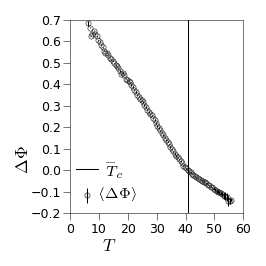

In [46]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
ax.errorbar(
    x,
    y,
    yerr=high - low,
    ms=5,
    fmt=".",
    mec="k",
    mfc="none",
    mew=0.25,
    ecolor="k",
    elinewidth=0.5,
    label="$\langle \Delta\Phi \\rangle$",
)
ax.text(
    0.4,
    0.06,
    f"$\langle \Delta\Phi \\rangle$",
    ha="right",
    va="bottom",
    fontsize=7,
    transform=ax.transAxes,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
    usetex=True,
    zorder=10,
)
ax.text(
    0.3,
    0.18,
    f"$T_c$",
    ha="right",
    va="bottom",
    fontsize=7,
    transform=ax.transAxes,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
    usetex=True,
    zorder=10,
)
ax.set_xlim(0, 60)
ax.set_ylim(-0.2, 0.6)
ax.set_xticks(arange(0, 70, 10))
ax.set_yticks(arange(-0.2, 0.8, 0.1))
ax.axvline(
    T_c,
    c="k",
    lw=0.5,
    ls="-",
    label="$T_c$",
)
ax.set_xlabel("Temperature $T$", usetex=True, labelpad=0)
ax.set_ylabel("Percolation $\Delta\Phi$", usetex=True, labelpad=0)
ax.legend(
    loc=[0, 0.015],
    frameon=False,
    handletextpad=0.5,
    handlelength=1.5,
    fontsize=7,
)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"percolation.pdf", format="pdf", transparent=True)

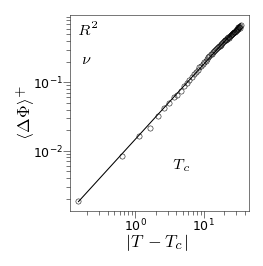

In [47]:
draw_law(renorm, y, r_value**2, save=False)

In [49]:
!latex --version

pdfTeX 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian)
kpathsea version 6.3.4/dev
Copyright 2021 Han The Thanh (pdfTeX) et al.
There is NO warranty.  Redistribution of this software is
covered by the terms of both the pdfTeX copyright and
the Lesser GNU General Public License.
For more information about these matters, see the file
named COPYING and the pdfTeX source.
Primary author of pdfTeX: Han The Thanh (pdfTeX) et al.
Compiled with libpng 1.6.37; using libpng 1.6.37
Compiled with zlib 1.2.11; using zlib 1.2.11
Compiled with xpdf version 4.03


## Animations

In [79]:
non_empty = []
empty = []
items = None
n_cars = 8
n_moto = 8
permutation = (n_cars, n_moto)
n_cars, n_moto = permutation
load = True
if load:
    items = loader(permutation, path="./output/")
for item in items:
    if isinstance(item[0], list):
        non_empty.append(item)
    else:
        empty.append(item)
len(non_empty)

(8, 8).json


254

In [80]:
max_lam = []
for i, item in enumerate(non_empty):
    l_lam = []
    for entry in item[0][1][-n_moto:]:
        l_lam.append(entry["lam"])
    max_lam.append(max(l_lam))
item = non_empty[np.argmin(max_lam)]

In [ ]:
from matplotlib.patches import Ellipse
from IPython.display import HTML
from numpy import arange, degrees
from numpy.linalg import norm
from copy import deepcopy

In [82]:
def draw(agent, ax):
    """Add this Particle's Ellipse patch to the Matplotlib Axes ax."""
    if agent["mode"] == "Car":
        width = 2 * params.car_l
        height = 2 * params.car_w
    else:
        width = 2 * params.moto_l
        height = 2 * params.moto_w
    ellipse = Ellipse(
        xy=agent["pos"],
        width=width,
        height=height,
        angle=degrees(agent["theta"]),
        **{"ec": "k", "fc": "w"},
    )
    ax.add_patch(ellipse)
    ax.scatter(
        agent["pos"][0],
        agent["pos"][1],
        marker="o",
        fc="k",
        ec="none",
        s=5,
    )
    if norm(agent["vel"]) > 0:
        ax.arrow(
            agent["pos"][0],
            agent["pos"][1],
            agent["vel"][0],
            agent["vel"][1],
            antialiased=True,
            width=0.1,
            head_width=0.5,
            head_length=0.75,
            color="k",
            zorder=2,
        )

In [83]:
def ring(t, l_agents, ax):
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-params.L / 2, params.L / 2)
    ax.set_ylim(-params.lane, params.lane)
    ax.set_axis_off()
    ax.hlines(
        [-params.lane, params.lane],
        xmin=-params.L / 2,
        xmax=params.L / 2,
        color="k",
        ls="-",
        lw=3,
    )
    for agent in l_agents[t]:
        if agent["pos"][0] < params.d_max:
            image = deepcopy(agent)
            image["pos"][0] += params.L
            draw(image, ax)
        elif agent["pos"][0] > params.d_max:
            image = deepcopy(agent)
            image["pos"][0] -= params.L
            draw(image, ax)
        draw(agent, ax)

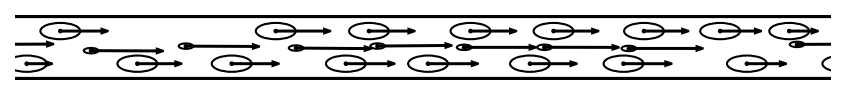

In [84]:
fig, ax = plt.subplots(figsize=(14.7 * params.cm, 2.5 * params.cm), dpi=150)
fig.tight_layout(pad=0)
ax.set_aspect("equal")
# frame = 1
# if frame < COUNT -1:
#    frame += 1
# else:
#    frame = 1
frame = -1
ring(frame, item[0], ax)

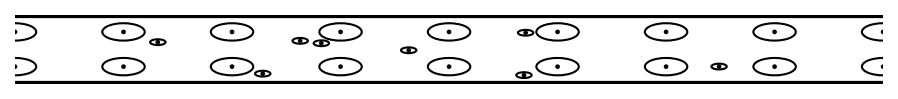

In [88]:
fig, ax = plt.subplots(figsize=(14.7 * params.cm, 2.5 * params.cm), dpi=150)
fig.tight_layout(pad=0)
ax.set_aspect("equal")


# def animate_ring(i, ax=ax):
#    ax.clear()
#    ring(i, item[0], ax)
def animate_ring(i, ax=ax, fig=fig):
    fig.tight_layout(pad=0)
    ax.clear()
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-params.L / 2, params.L / 2)
    ax.set_ylim(-params.lane, params.lane)
    ax.set_axis_off()
    ring(i, item[0], ax)


# Create the animation
ani_ring = animation.FuncAnimation(fig, animate_ring, frames=range(0, len(item[0]), 1))

In [95]:
# Save the animation as an HTML video
# ani_ring_html = ani_ring.to_jshtml()

In [94]:
# Display the HTML video
# HTML(ani_ring_html)

In [ ]:
#file = r"ring.gif"
#writergif = animation.PillowWriter(fps=1 / params.dt)
#ani_ring.save(file, writer=writergif)
file = r"./demos/demo.gif"
writergif = animation.PillowWriter(fps=1 / params.dt)
ani_ring.save(file, writer=writergif)

In [ ]:
def navi(t, l_agents, ID, ax):
    a_des = l_agents[t][ID - 1]["a_des"]
    a0 = l_agents[t][ID - 1]["a0"]
    alphas = l_agents[t][ID - 1]["alphas"]
    f_a = l_agents[t][ID - 1]["f_a"]
    ax.invert_xaxis()
    ax.set_yticks([])
    ax.plot(np.degrees(alphas), f_a, c="k", clip_on=False)
    ax.scatter(np.degrees(a_des), 0, clip_on=False, marker="+", c="k")
    ax.spines["left"].set_position("zero")
    ax.set_xlabel("Direction $α$ ($\deg$)")
    ax.axhline(params.d_max, color="k", ls="--")
    ax.axvline(np.degrees(a0), color="k", ls=":")
    ax.text(np.degrees(a0) + 2, params.d_max + 0.5, "$α_0$")
    ax.set_ylim(0, params.d_max)
    ax.spines[["top", "right"]].set_visible(False)

In [ ]:
ID = 2 * n_cars + n_moto
ID

In [ ]:
fig, ax = plt.subplots(figsize=(6 * params.cm, 5 * params.cm), dpi=150)
fig.tight_layout(pad=0)
# frame = 1
# if frame < COUNT -1:
#    frame += 1
# else:
#    frame = 1
frame = -1
navi(frame, item[0], ID, ax)

In [ ]:
fig, ax = plt.subplots(figsize=(6 * params.cm, 5 * params.cm), dpi=150)


def animate_navi(i, ax=ax):
    ax.clear()
    ax = navi(i, item[0], ID, ax)


# Create the animation
ani_navi = animation.FuncAnimation(fig, animate_navi, frames=range(1, len(item[0]), 1))

In [ ]:
# Save the animation as an HTML video
ani_navi_html = ani_navi.to_jshtml()

In [ ]:
f = r"navi.gif"
writergif = animation.PillowWriter(fps=1 / params.dt)
ani_navi.save(f, writer=writergif)